In [1]:
import uproot
import numpy as np
import numba
import matplotlib.pyplot as plt
import hist as hephist
from matplotlib.ticker import MaxNLocator,AutoMinorLocator # for minor ticks
from lmfit.models import PolynomialModel, GaussianModel # for the signal and background fits
from sklearn.gaussian_process import GaussianProcessRegressor 
import scipy.optimize
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, ExpSineSquared, DotProduct, WhiteKernel, ConstantKernel as C
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.pipeline import Pipeline
import pandas as pd
import scipy.stats
from scipy import integrate as intg 
from scipy.integrate import trapz, simps, quad
import math
from uncertainties import ufloat
import seaborn as sns
#sns.set_theme()
#df = sns.load_dataset("penguins")
from numba import njit
import random
from pathlib import Path
#%matplotlib inline
%matplotlib widget

import ROOT
from ROOT import TH1D, TCanvas,TH2D


Welcome to JupyROOT 6.24/06


In [2]:
## customized class
from  help_class.model import gpr_model


In [3]:
global_pT_bins = [0., 0.4, .65, 1.]
# pT_min = global_pT_bins[0]
# pT_max = global_pT_bins[1]
filepT="file_pt1.root"
# pT_max
gmc_pT_min = 0.
gmc_pT_max = .40



In [4]:
#fit2D_1 = ROOT.TF2("fit2D_1", "[0] * ( 1 + [1]*y*y + 2*[2]*sqrt(1-y*y)*y*cos(x) + [3]*(1-y*y)*cos(2*x)/2.) ", -3.1, 3.1, -0.45, 0.45)
fit2D = ROOT.TF2("fit2D", "[0] * ( 1 + [1]*y*y + 2*[2]*sqrt(1-y*y)*y*cos(x) + [3]*(1-y*y)*cos(2*x)/2.) ", -3.14, 3.14, -0.5, 0.5)
acc_file_allpT = ROOT.TFile.Open("/Users/abinashpun/E906_projects/root_files/acc_factor.root") 
acc_file = ROOT.TFile.Open("/Users/abinashpun/E906_projects/root_files/acc_factor_3pTbins.root","READ")
#acc_hist = acc_file.accepted_hist


In [5]:
acc_hist_1 = acc_file.h2_phi_costh_ipt_1
acc_hist_2 = acc_file.h2_phi_costh_ipt_2
acc_hist_3 = acc_file.h2_phi_costh_ipt_3
# acc_hist_4 = acc_file.h2_phi_costh_ipt_4

acc_hist_all = acc_file_allpT.accepted_hist


## Read the file


In [6]:
#file = uproot.open("../../root_files/merged_RS67_3089LD2.root",object_cache=1000)

data_folder = Path("/Users/abinashpun/E906_projects/root_files")
file = uproot.open(data_folder/"merged_RS67_3087all_target.root",object_cache=1000)
#file = uproot.open("../../root_files/reduced_RS67_3087all_target_looseDumpcut_unmixed.root",object_cache=1000)

result_tree = file['result']



In [7]:

result_mix_tree = file['result_mix']

In [8]:
#MonteCarlo files
jpsi_file = uproot.open(data_folder/"mc_jpsi_dump_M026_S002_messy_all_0_mix1_pT_D.root")
jpsi_tree = jpsi_file['Tree']


psiprime_file = uproot.open(data_folder/"mc_psiprime_dump_M026_S002_messy_all_0_mix1_pT_D.root")
psiprime_tree = psiprime_file['Tree']


In [9]:
df_real = result_tree.arrays(library="pd") #to get as pandas data frame
df_real.head()



,runID,spillID,eventID,D1,D2,D3,occuD3m,occuD3p,rfp00c,pot_p00,...,nHits2St2,nHits2St3,chisq1,chisq1_upstream,chisq1_target,chisq1_dump,chisq2,chisq2_upstream,chisq2_target,chisq2_dump
0,12525,485007,146438,719,806,952,438,514,1530.630005,26480.400391,...,4,5,3.578541,71.281677,30.915342,3.781781,0.112139,5.566748,13.477578,149.046280
1,12525,484980,87282,708,601,667,378,289,2234.629883,38549.203125,...,5,5,2.916970,65.637802,32.038200,5.515533,1.236574,32.024467,15.649112,2.037855
2,12525,485000,128195,594,349,394,248,146,2938.629883,50774.175781,...,5,6,1.381539,101.921661,76.685783,46.323097,0.440945,0.812212,0.074278,0.172446
3,12525,485000,128195,594,349,394,248,146,2938.629883,50774.175781,...,5,5,1.381539,101.921661,76.685783,46.323097,2.753839,105.044228,28.610647,5.392654
4,12525,484975,74553,586,740,747,373,374,858.630005,14821.538086,...,5,5,11.963326,81.599571,59.740093,36.749580,0.402625,17.412228,2.856654,1.795740


In [10]:
df_mix = result_mix_tree.arrays(library="pd")
df_mix.head()




,runID,spillID,D1,D2,D3,ptrk_D1,ptrk_D2,ptrk_occuD3m,ptrk_occuD3p,ptrk_rfp00c,...,nHits2St2,nHits2St3,chisq1,chisq1_upstream,chisq1_target,chisq1_dump,chisq2,chisq2_upstream,chisq2_target,chisq2_dump
0,12525,0,583,675,847,583,757,469,465,-32.369999,...,5,4,0.300416,0.607049,51.581818,341.175232,10.847273,17.380821,10.696171,63.126820
1,12525,0,583,675,847,583,757,469,465,-32.369999,...,5,4,4.810805,21.921455,3.990668,26.767950,10.847273,17.380821,10.696171,63.126820
2,12525,0,539,481,547,539,330,245,206,4218.629883,...,4,5,42.873497,89.747673,66.826385,45.930878,1.513134,174.036285,113.027443,48.298931
3,12525,0,533,278,381,533,284,153,224,986.630005,...,4,5,10.999554,20.256880,8.667981,66.890396,25.264532,177.403290,116.857994,55.233116
4,12525,0,480,197,223,480,198,125,103,1850.630005,...,6,5,21.058973,69.367920,43.318829,23.155361,0.746363,14.419147,6.070827,1.092052


In [11]:
df_jpsi = jpsi_tree.arrays(library="pd")
df_psip = psiprime_tree.arrays(library="pd")
df_jpsi.head()

,runN,spillID,eventID,mass,px1,py1,pz1,px2,py2,pz2,...,xFMC,xBMC,DmxMC,DmyMC,DmzMC,DmpxMC,DmpyMC,DmpzMC,pT,pTMC
0,9999999.0,1.0,21.0,3.116348,-1.358030,0.496523,45.531330,1.632815,0.963589,36.121407,...,0.640394,0.678252,0.173805,1.513720,36.021835,-0.163249,0.882976,81.965698,1.485744,0.897940
1,9999999.0,1.0,30.0,2.972875,-1.472008,0.426493,61.485676,1.367287,-0.041117,33.266380,...,0.768293,0.788018,0.239960,1.777705,158.189056,-0.148429,0.519086,95.252548,0.399350,0.539890
2,9999999.0,1.0,47.0,2.858258,-1.428714,-1.058981,48.673313,1.400619,-0.926581,55.770000,...,0.848889,0.871367,-0.311408,1.332886,51.261780,0.053299,-1.617451,105.326920,1.985761,1.618329
3,9999999.0,1.0,52.0,3.278536,-0.838017,-0.637284,74.176071,1.462656,-1.186166,28.158257,...,0.809563,0.840532,-0.617051,1.029569,26.010904,0.979097,-1.583324,101.591293,1.927471,1.861598
4,9999999.0,1.0,58.0,3.243264,-1.554793,0.491832,31.377087,1.375291,-0.179212,58.932350,...,0.708763,0.734765,-0.771225,1.312855,62.331604,-0.092728,0.454776,88.808693,0.360489,0.464133


## Dump Data Cuts

In [12]:
def Dump_PosTrk_cut(df_p):
    ptrk_chisq_mask = (df_p['chisq1_dump']<40.) & (df_p['chisq1_dump']>0.) &\
                         (df_p['chisq1_target'] >5.) & (df_p['chisq1_upstream']>20.)&\
                         (df_p['nHits1']>13)
    
    ptrk_mom_mask = (df_p['pz1_st1']>10) & (df_p['pz1_st1']<80) &\
                    (np.fabs(df_p['py1_st1']-df_p['py1_st3']) < 0.008) &\
                    (np.fabs(df_p['pz1_st1']-df_p['pz1_st3']) < 0.05)
                         
    ptrk_pos_mask = (df_p['z1_v']<250) & (df_p['z1_v']>-50) &\
                    (df_p['y1_st1']/df_p['y1_st3']<1) &\
                    ((df_p['x1_t']**2+(df_p['y1_t']-1.6)**2)<1500) & ((df_p['x1_t']**2+(df_p['y1_t']-1.6)**2)>15) &\
                    ((df_p['x1_d']**2+(df_p['y1_d']-1.6)**2)<300)
                   
    return (ptrk_chisq_mask) & ( ptrk_mom_mask) & (ptrk_pos_mask )
    

    
def Dump_NegTrk_cut(df_n):    
    ntrk_chisq_mask = (df_n['chisq2_dump']<40.) & (df_n['chisq2_dump']>0.) &\
                         (df_n['chisq2_target'] >5.) & (df_n['chisq2_upstream']>20.)&\
                         (df_n['nHits2']>13)
    
    ntrk_mom_mask = (df_n['pz2_st1']>10) & (df_n['pz2_st1']<80) &\
                    (np.fabs(df_n['py2_st1']-df_n['py2_st3']) < 0.008) &\
                    (np.fabs(df_n['pz2_st1']-df_n['pz2_st3']) < 0.05)
                         
    ntrk_pos_mask = (df_n['z2_v']<250) & (df_n['z2_v']>-50) &\
                    (df_n['y2_st1']/df_n['y2_st3']<1) &\
                    ((df_n['x2_t']**2+(df_n['y2_t']-1.6)**2)<1500) & ((df_n['x2_t']**2+(df_n['y2_t']-1.6)**2)>15) &\
                    ((df_n['x2_d']**2+(df_n['y2_d']-1.6)**2)<300)
    
    return (ntrk_chisq_mask) & (ntrk_mom_mask) & (ntrk_pos_mask)


def Dump_dim_cut(df_d): 
    vtx_mask =   (df_d['dz'] > -10.) & (df_d['dz'] < 250.) &\
                  (np.fabs(df_d['dx'])<0.45) & (np.fabs(df_d['dy']-1.6)<0.40) &\
                  ((df_d['dx']**2+(df_d['dy']-1.6)**2)<0.2)
    
    mom_mask = (np.fabs(df_d['dpx'])<1.5) & (np.fabs(df_d['dpy'])<3.5) &\
                (np.fabs(df_d['dpz'])<118) & (np.fabs(df_d['dpz'])>35.) &\
                ((df_d['dpx']**2 + df_d['dpy']**2) < 5.)
    
    both_trk_mask = (np.fabs(df_d['trackSeparation']) < 200.) &\
                    (np.fabs(df_d['x1_st1']+df_d['x2_st1'])<20.) & ((df_d['nHits1']+df_d['nHits2'])>29) &\
                    ((df_d['nHits1St1']+df_d['nHits2St1'])>8)

    chisq_mask = (df_d['chisq_dimuon'] < 20.) & (df_d['chisq_dimuon']>0.)
                

    return (vtx_mask) & (mom_mask) & (both_trk_mask) & (chisq_mask)
    
def Dump_Physics_cut(df_ph):
    phycs_mask =  (np.fabs(df_ph['costh'])<0.5) &\
                    (df_ph['xF'] > 0.2) & (df_ph['xF'] < .95) &\
                    (df_ph['mass']<10.) & (df_ph['mass']>0.1) &\
                    (df_ph['pT'] > 0.) & (df_ph['pT'] < 2.5)
    return phycs_mask
    
    
def Dump_Occu_cut(df_):                   
    occu_mask = (df_['D1']<100) & (df_['D2']<400) & ((df_['D3'])<400) &\
            ((df_['D1']+df_['D2'] + df_['D3']) <1000) &\
            (df_['pot_p00']<80000.) & (df_['pot_p00']>0.)
    return occu_mask

## Dump GMC Cuts (For Andrew's GMC file)

In [13]:
def DumpGMC_PosTrk_cut(df_p):
    ptrk_chisq_mask = (df_p['TpChiDp']<40.) & (df_p['TpChiDp']>0.) &\
                         (df_p['TpChiTg'] >5.) & (df_p['TpChiUp']>20.) &\
                         (df_p['TpnHit']>13) 
    ptrk_pos_mask =  (df_p['Tpz0']<250) & (df_p['Tpz0']>-50) &\
                    ((df_p['TpxT']**2+(df_p['TpyT']-1.6)**2)<1500) & ((df_p['TpxT']**2+(df_p['TpyT']-1.6)**2)>15) &\
                    ((df_p['TpxD']**2+(df_p['TpyD']-1.6)**2)<300)
    
    ptrk_mom_mask = (df_p['TpPz1']>10) & (df_p['TpPz1']<80) &\
                    (np.fabs(df_p['TpPy1']-df_p['TpPy3'])<0.008) & (np.fabs(df_p['TpPz1']-df_p['TpPz3'])<0.05)

    
    return (ptrk_chisq_mask) & (ptrk_pos_mask) & (ptrk_mom_mask)
    
def DumpGMC_NegTrk_cut(df_):
    
    ntrk_chisq_mask = (df_['TnChiDp']<40.) & (df_['TnChiDp']>0.) &\
                         (df_['TnChiTg'] >5.) & (df_['TnChiUp']>20.) &\
                         (df_['TnnHit']>13)
    
    ntrk_pos_mask =  (df_['Tnz0']<250) & (df_['Tnz0']>-50) &\
                    ((df_['TnxT']**2+(df_['TnyT']-1.6)**2)<1500) & ((df_['TnxT']**2+(df_['TnyT']-1.6)**2)>15) &\
                    ((df_['TnxD']**2+(df_['TnyD']-1.6)**2)<300)                    
    
    ntrk_mom_mask = (df_['TnPz1']>10) & (df_['TnPz1']<80) &\
                    (np.fabs(df_['TnPy1']-df_['TnPy3'])<0.008) & (np.fabs(df_['TnPz1']-df_['TnPz3'])<0.05)
        
    return (ntrk_chisq_mask) & (ntrk_pos_mask) & (ntrk_mom_mask)

def DumpGMC_dim_cut(df_d): 
    vtx_mask =   (df_d['Dmz'] > -10.) & (df_d['Dmz'] < 250.)
    
    both_trk_mask = (np.fabs(df_d['Tnz0']-df_d['Tpz0']) < 200.) &\
                    (np.fabs(df_d['Tpx1']+df_d['Tnx1'])<20.) &\
                    ((df_d['TpnHit']+df_d['TnnHit'])>29) & ((df_d['TpnHit1']+df_d['TnnHit1'])>8)
    
    chisq_mask = (df_d['Dmchisq'] < 20.) & (df_d['Dmchisq']>0.)
    
    mom_mask = (np.fabs(df_d['Dmpx'])<1.5) & (np.fabs(df_d['Dmpy'])<3.5) &\
                ((df_d['Dmpx']**2+df_d['Dmpy']**2)<5.) &\
                (np.fabs(df_d['Dmpz'])<118.) & (np.fabs(df_d['Dmpz'])>38.) 
    
    
    pos_mask = (np.fabs(df_d['Dmx'])<.45) & (np.fabs(df_d['Dmy']-1.6)<.40) &\
                ((df_d['Dmx']**2 + (df_d['Dmy']-1.6)**2)<0.2)

    
    return (vtx_mask) & (both_trk_mask) & (chisq_mask) & (mom_mask) & (pos_mask)
    
def DumpGMC_Physics_cut(df_ph):
    phycs_mask =  (np.fabs(df_ph['Dmcosth'])<0.5) &\
                    (df_ph['DmxF'] > 0.2) & (df_ph['DmxF'] < .95) &\
                    (df_ph['mass']<10.) & (df_ph['mass']>0.1) &\
                    (df_ph['MATRIX1']>0) & ( (df_ph['TprdID']*df_ph['TnrdID'])<0.) &\
                    (df_ph['pT']>gmc_pT_min) & (df_ph['pT']<gmc_pT_max)
    return phycs_mask
    
    
def DumpGMC_Occu_cut(df_):                   
    occu_mask = (df_['D1']<100) & (df_['D2']<400) & ((df_['D3'])<400) &\
            ((df_['D1']+df_['D2'] + df_['D3']) <1000) &\
            (df_['pot_p00']<80000.) & (df_['pot_p00']>0.)
    return occu_mask


### Fill Data Histogram

In [14]:
xmin = 1. # GeV (mass)
xmax = 9. # GeV
step_size = 0.15 # GeV
    
bin_edges = np.arange(start=xmin, # The interval includes this value
                     stop=xmax+step_size, # The interval doesn't include this value
                     step=step_size ) # Spacing between values
bin_centres = np.arange(start=xmin+step_size/2, # The interval includes this value
                            stop=xmax+step_size/2, # The interval doesn't include this value
                            step=step_size ) # Spacing between values

# print(bin_edges.shape)
# print(bin_centres.shape)

def fill_hist(data):
    data_x,_ = np.histogram(data, 
                               bins=bin_edges ) # histogram the data
    data_x_errors = np.sqrt(data_x) # statistical error on the data
    
    return data_x, data_x_errors

In [15]:
def plot_gpr(bin_centres, m, m_err, gpr_predict, gpr_sigma):
    fig = plt.figure(figsize=(10,6))

    plt.errorbar(x=bin_centres, y = m, yerr=m_err, fmt='o', color="blue",label="Real Data")

    pred_axes = plt.gca()
    pred_axes.plot(bin_centres,gpr_predict, label="Mean prediction from GPR",color='orange',linestyle='--',linewidth=2)

    pred_axes.fill_between(
        bin_centres.ravel(),
        gpr_predict - 1.96 * gpr_sigma,
        gpr_predict + 1.96 * gpr_sigma,
        alpha=0.5,
        label=r"95% confidence interval",
        color='orange'
    )
    plt.legend()
    plt.legend(prop={'size':15})
    plt.xticks(np.arange(xmin, xmax+1, 1.0))
    plt.xlabel('Dimuon Mass $[GeV/c^2]$',
                            x=1, horizontalalignment='right', 
                            fontsize=18 ) 
    plt.axvspan(sideband[0], sideband[1], alpha=0.2, color='red')
    plt.axvspan(sideband[2], sideband[3], alpha=0.2, color='red')
    plt.ylim(bottom=-20000.0)
    plt.grid(True)
    plt.show()

### Implment Cuts

In [16]:
Dump_real_PosTrk_cut = Dump_PosTrk_cut(df_real)
Dump_real_NegTrk_cut = Dump_NegTrk_cut(df_real)
Dump_real_Physics_cut = Dump_Physics_cut(df_real)
Dump_real_Occu_cut = Dump_Occu_cut(df_real)
Dump_real_dim_cut = Dump_dim_cut(df_real)

Dump_real_data_cut = (Dump_real_PosTrk_cut) & (Dump_real_NegTrk_cut) & (Dump_real_Physics_cut) & (Dump_real_dim_cut) & (Dump_real_Occu_cut)


Dump_mix_PosTrk_cut = Dump_PosTrk_cut(df_mix)
Dump_mix_NegTrk_cut = Dump_NegTrk_cut(df_mix)
Dump_mix_Physics_cut = Dump_Physics_cut(df_mix)
Dump_mix_Occu_cut = Dump_Occu_cut(df_mix)
Dump_mix_dim_cut = Dump_dim_cut(df_mix)

Dump_mix_data_cut = (Dump_mix_PosTrk_cut) & (Dump_mix_NegTrk_cut) & (Dump_mix_Physics_cut)  & (Dump_mix_dim_cut) & (Dump_mix_Occu_cut)


In [17]:
DumpGMC_jpsi_PosTrk_cut = DumpGMC_PosTrk_cut(df_jpsi)
DumpGMC_jpsi_NegTrk_cut = DumpGMC_NegTrk_cut(df_jpsi)
DumpGMC_jpsi_Physics_cut = DumpGMC_Physics_cut(df_jpsi)
#DumpGMC_jpsi_Occu_cut  =  DumpGMC_Occu_cut(df_jpsi)
DumpGMC_jpsi_dim_cut = DumpGMC_dim_cut(df_jpsi)


jpsi_mask = (DumpGMC_jpsi_PosTrk_cut) & (DumpGMC_jpsi_NegTrk_cut) & (DumpGMC_jpsi_Physics_cut) & (DumpGMC_jpsi_dim_cut) #& (DumpGMC_jpsi_Occu_cut)


DumpGMC_psip_PosTrk_cut = DumpGMC_PosTrk_cut(df_psip)
DumpGMC_psip_NegTrk_cut = DumpGMC_NegTrk_cut(df_psip)
DumpGMC_psip_Physics_cut = DumpGMC_Physics_cut(df_psip)
DumpGMC_psip_dim_cut = DumpGMC_dim_cut(df_psip)
#DumpGMC_psip_Occu_cut = DumpGMC_Occu_cut(df_psip)
psip_mask = (DumpGMC_psip_PosTrk_cut) & (DumpGMC_psip_NegTrk_cut) & (DumpGMC_psip_Physics_cut) & (DumpGMC_psip_dim_cut) #& (DumpGMC_psip_Occu_cut)


jpsi_mass=0.99*df_jpsi['mass'][jpsi_mask]
psip_mass=0.99*df_psip['mass'][psip_mask]


## Choose side bands

In [18]:
sideband = np.array([1.75, 2.5, 4.5, 7.])

## J/Psi and Psi' Model with PDF

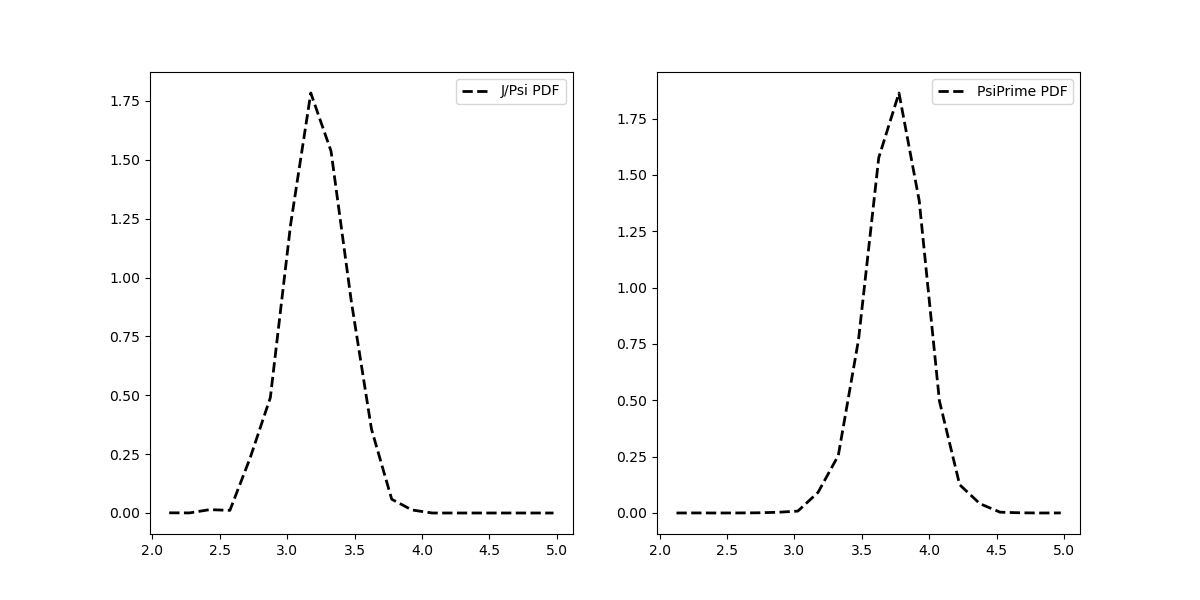

In [19]:

mass_nbins = int((xmax-xmin)/step_size)

jpsi_hist = np.histogram(jpsi_mass, weights= df_jpsi['sigWeight'][jpsi_mask], range=(xmin,xmax), 
                           bins=mass_nbins)
jpsi_dist = scipy.stats.rv_histogram(jpsi_hist)


psiprime_hist = np.histogram(psip_mass, weights=df_psip['sigWeight'][psip_mask], range=(xmin,xmax),
                            bins=mass_nbins) 

psiprime_dist = scipy.stats.rv_histogram(psiprime_hist)


def jpsi_pdf(x, amp):
    #return (amp*jpsi_dist.pdf(x)/jpsi_hist[0].sum())
    return (amp*jpsi_dist.pdf(x))
def psiprime_pdf(x, amp):
    #return (amp*psiprime_dist.pdf(x)/psiprime_hist[0].sum())
    return (amp*psiprime_dist.pdf(x))   


fig, axes1 = plt.subplots(1, 2, figsize=(12, 6))
m_start = np.where(bin_centres>=2.)[0][0]
m_end = np.where(bin_centres >=5.)[0][0] #i.e fitting from 2 - 5 GeV
x=bin_centres[m_start:m_end]
axes1[0].plot(x, jpsi_dist.pdf(x), '--', label='J/Psi PDF',linewidth=2,color="black")
axes1[0].legend()
axes1[1].plot(x, psiprime_dist.pdf(x), '--', label='PsiPrime PDF',linewidth=2,color="black")
axes1[1].legend()
plt.show()

In [20]:
from lmfit import Model
from lmfit import Parameters, fit_report, minimize

jpsi_model = Model(jpsi_pdf, prefix='jpsi_')
pars=(jpsi_model.make_params())
pars['jpsi_amp'].set(value=10)


psip_model = Model(psiprime_pdf, prefix='psip_')
pars.update(psip_model.make_params())
pars['psip_amp'].set(value=1)   

model_peaks = jpsi_model + psip_model

In [21]:
#playground for making class of J/Psi and Psi' pdf

from lmfit import Model as lm_Model
from lmfit import Parameters, fit_report, minimize

# jpsi_mass=0.99*df_jpsi['mass'][jpsi_mask]
# psip_mass=0.99*df_psip['mass'][psip_mask]

class jpsi_psip_model:
    def __init__(self,jpsi_mass, psip_mass, jpsi_wt,psip_wt):
        self.jpsi_mass = df_jpsi
        self.psip_mass = df_psip
        self.jpsi_wt = jpsi_wt
        self.psip_wt = psip_wt

        #making pdf for j/psi and psi'

        jpsi_hist = np.histogram(jpsi_mass, weights= jpsi_wt, range=(1.,9.), 
                                   bins=80)

        self.jpsi_dist = scipy.stats.rv_histogram(jpsi_hist)

        psiprime_hist = np.histogram(psip_mass, weights=psip_wt, range=(1.,9.),
                                    bins=80) 
        self.psiprime_dist = scipy.stats.rv_histogram(psiprime_hist)
               

    def jpsi_pdf(self,x, amp):
        jpsi_dist = self.jpsi_dist
        return (amp*jpsi_dist.pdf(x))
    
    def psiprime_pdf(self,x, amp):
        psiprime_dist = self.psiprime_dist
        return (amp*psiprime_dist.pdf(x))  


    def get_model_peaks(self):
        jpsi_model = lm_Model(self.jpsi_pdf, prefix='jpsi_')
        pars=(jpsi_model.make_params())
        pars['jpsi_amp'].set(value=10)
        
        psip_model = lm_Model(self.psiprime_pdf, prefix='psip_')
        pars.update(psip_model.make_params())
        pars['psip_amp'].set(value=1)
        model_peaks = jpsi_model + psip_model
        return model_peaks 

## Implementing GPR Model

In [22]:
total_real_m=df_real['mass'][Dump_real_data_cut]
total_mix_m=df_mix['mass'][Dump_mix_data_cut]


total_real_m, total_real_m_err = fill_hist(total_real_m)
total_mix_m, total_mix_m_err = fill_hist(total_mix_m)

#total_signal = total_real_m - total_mix_m
total_signal = total_real_m
#total_signal_err= np.sqrt(np.square(total_real_m_err)+np.square(total_mix_m_err))
total_signal_err = total_real_m_err 

#GPR method
total_data_model = gpr_model()
total_stacked_data=np.column_stack((np.array(bin_centres),np.array(total_signal), np.array(total_signal_err)))

total_data_model.set_sideband(sideband,total_stacked_data)
total_data_model.set_kernel(5e4, (1e-10, 1e25),5,(1e-5, 1e25))
total_gpr_pred, total_gpr_sigma, total_gpr_err = total_data_model.predict(1000)

/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


kernel :  6.41e+04**2 * RBF(length_scale=0.95)
score =  0.5053600871223854
Log-likelihood: -189.471


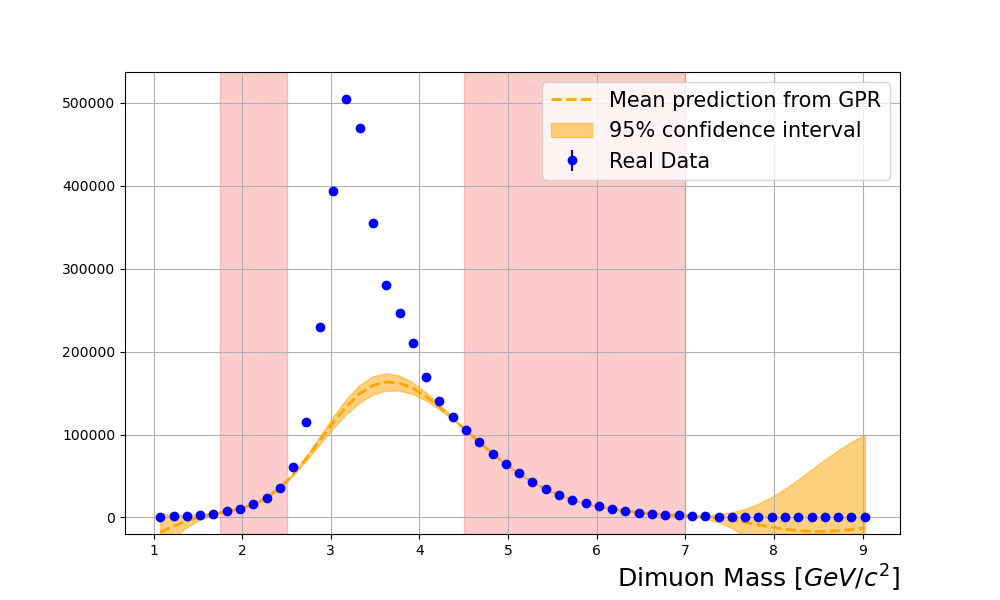

In [23]:
plot_gpr(bin_centres, total_signal, total_signal_err, total_gpr_pred, total_gpr_sigma)

In [24]:
#print(bin_centres)
#print(np.where(bin_centres>=5.)[0][0]) 

## Total J/Psi and Psi' yield

7 27
Reduced Chisq:  2.6494146957346048
JPsi yield:  1408487.6346764723 +/- 37995.36953369952
Psi-Prime yield:  234687.63606090637 +/- 30318.909740387495


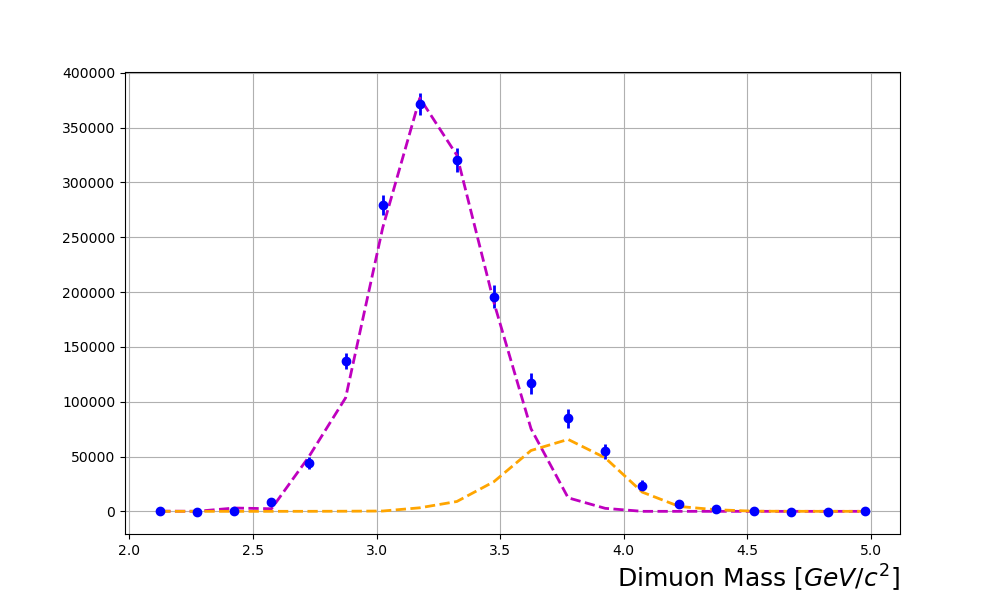

In [25]:
total_peaks_signal=total_signal-total_gpr_pred
total_peaks_signal_error = np.sqrt(np.square(total_signal_err)+np.square(total_gpr_err))

m_start = np.where(bin_centres>=2.)[0][0]
m_end = np.where(bin_centres >=5.)[0][0] #i.e fitting from 2 - 5 GeV

print(m_start, m_end)
    
x=bin_centres[m_start:m_end]
y=total_peaks_signal[m_start:m_end]
y_err=total_peaks_signal_error[m_start:m_end]


total_result_peaks = model_peaks.fit(y,pars,x=x, weights=(1.0/(y_err)))
total_comps = total_result_peaks.eval_components(x=x)

fig = plt.figure(figsize=(10,6))
plt.errorbar(x,y,yerr=y_err,linewidth=2,color="blue",fmt='o')
plt.plot(x, total_comps['jpsi_'], '--',linewidth=2,color="m")
plt.plot(x, total_comps['psip_'], '--',linewidth=2, color="orange")
#plt.legend()
#plt.yscale('log')
plt.grid(True)
plt.xlabel('Dimuon Mass $[GeV/c^2]$',
           x=1, horizontalalignment='right', 
                            fontsize=18 ) 
print("Reduced Chisq: ",total_result_peaks.redchi)
print("JPsi yield: ", total_result_peaks.params['jpsi_amp'].value/step_size, "+/-",total_result_peaks.params['jpsi_amp'].stderr/step_size)
print("Psi-Prime yield: ",total_result_peaks.params['psip_amp'].value/step_size, "+/-", total_result_peaks.params['psip_amp'].stderr/step_size)
plt.show()

## Total pT Distribution

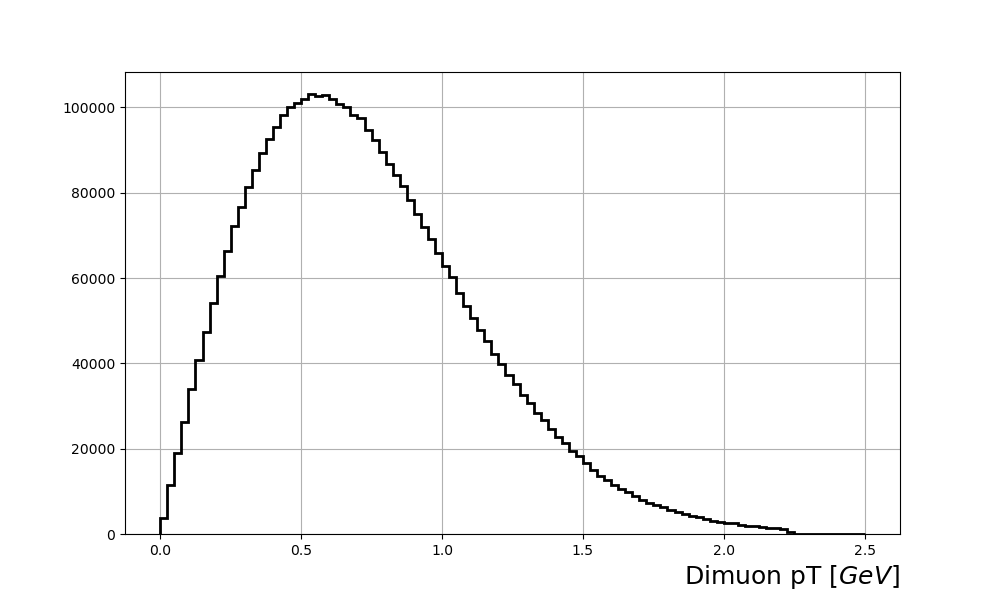

float32


In [26]:
fig = plt.figure(figsize=(10,6))
pt_real = df_real['pT'][Dump_real_data_cut]
plt.hist(pt_real, bins=100, range = (0,2.5), color='black', histtype='step', density=False, linewidth=2,)
plt.grid(True)
plt.xlabel('Dimuon pT $[GeV]$', x=1, horizontalalignment='right', fontsize=18 ) 
plt.show()
pt_real.shape
print((pt_real.dtype))

## Total xF Distribution

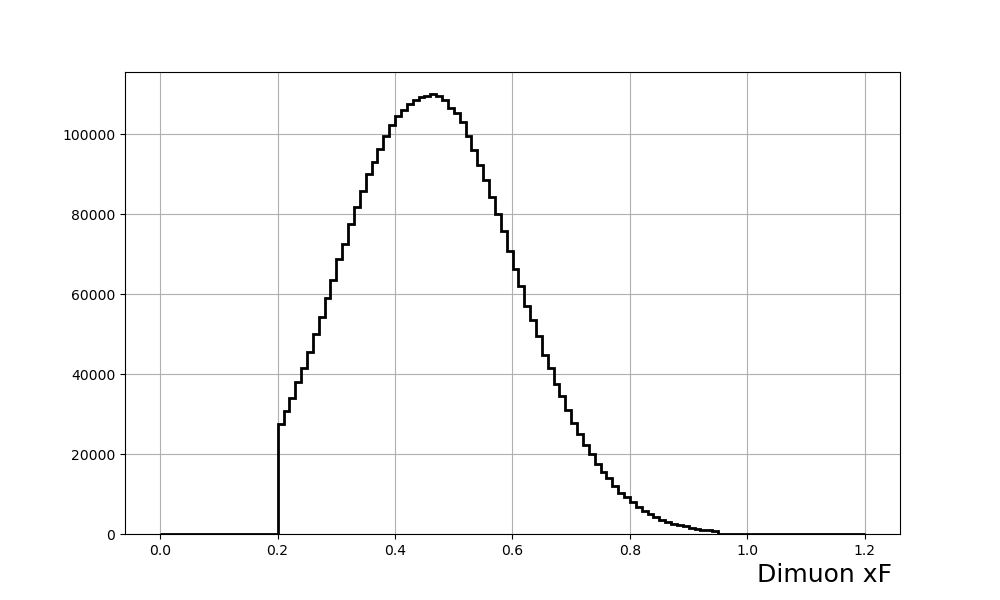

In [27]:
fig = plt.figure(figsize=(10,6))
pt_real = df_real['xF'][Dump_real_data_cut]
plt.hist(pt_real, bins=120, range = (0,1.2), color='black', histtype='step', density=False, linewidth=2,)
plt.xlabel('Dimuon xF ', x=1, horizontalalignment='right', fontsize=18 )
plt.grid(True)
plt.show()

# Loop over the pT and phi-costh Bins

In [28]:

npTBins = 1
pT_min = gmc_pT_min
pT_max = gmc_pT_max
pT_bins = (np.linspace(pT_min, pT_max, npTBins+1))
#pT_bins = [0., 0.4, 0.7, 1.0, 2.0]
#pT_bins = global_pT_bins
print(pT_bins)

nPhiBins = 6
phi_min =-3.14#-3.1415926#-math.pi
phi_max =3.14#3.1415926 #math.pi
phi_bins = (np.linspace(phi_min, phi_max, nPhiBins+1))

#print(phi_bins)

nCosthBins = 6
costh_min = -0.4
costh_max = 0.4
costh_bins = np.linspace(costh_min,costh_max,nCosthBins+1)

[0.  0.4]


In [29]:
#Folder for plots
plot_folder = Path("/Users/abinashpun/E906_projects/gpr_work/bin_plots")

# Turn interactive plotting off as there will be millions of plots
plt.ioff()

myFile = ROOT.TFile.Open(filepT, "RECREATE")
gpr_phi_costh_hist = TH2D("gpr_phi_costh","phi vs costh;#phi;cos#theta",nPhiBins,phi_min,phi_max,nCosthBins,costh_min,costh_max)
gpr_costh_hist = TH1D("gpr_costh","costh;#phi;",phi_max,nCosthBins,costh_min,costh_max)
#gpr_phi_costh_hist.SetDirectory(0)

for pT_index, elem_pT in enumerate(pT_bins):
    if pT_index >= len(pT_bins)-1:
        continue
    print(pT_index)
    print(pT_bins[pT_index], pT_bins[pT_index+1])

    low_pT=f'{pT_bins[pT_index]:1.2f}'
    high_pT=f'{pT_bins[pT_index+1]:1.2f}'
    
    real_pt_mask = (df_real['pT']>=pT_bins[pT_index]) & (df_real['pT']<pT_bins[pT_index+1])
    mix_pt_mask = (df_mix['pT']>=pT_bins[pT_index]) & (df_mix['pT']<pT_bins[pT_index+1])

    for phi_index, elem_phi in enumerate(phi_bins):
        if phi_index >= len(phi_bins)-1:
            continue
        #print(phi_index)
        #print(phi_bins[phi_index], phi_bins[phi_index+1])
        
        real_phi_mask = (df_real['phi']>=phi_bins[phi_index]) & (df_real['phi']<phi_bins[phi_index+1])
        mix_phi_mask = (df_mix['phi']>=phi_bins[phi_index]) & (df_mix['phi']<phi_bins[phi_index+1])


        jpsi_phi_mask = (df_jpsi['phi']>=phi_bins[phi_index]) & (df_jpsi['phi']<phi_bins[phi_index+1])
        psip_phi_mask = (df_psip['phi']>=phi_bins[phi_index]) & (df_psip['phi']<phi_bins[phi_index+1])


        for costh_index, elem_costh in enumerate(costh_bins):
            if costh_index >= len(costh_bins)-1:
                continue
            #print(costh_bins[costh_index], costh_bins[costh_index+1])
            #print(costh_index)
            real_costh_mask = (df_real['costh']>=costh_bins[costh_index]) & (df_real['costh']<costh_bins[costh_index+1])
            mix_costh_mask = (df_mix['costh']>=costh_bins[costh_index]) & (df_mix['costh']<costh_bins[costh_index+1])


            total_real_cut = (Dump_real_data_cut) & (real_phi_mask) & (real_costh_mask) & (real_pt_mask) 
            total_mix_cut = (Dump_mix_data_cut) & (mix_phi_mask) & (mix_costh_mask) & (mix_pt_mask) 

            real_mass=df_real['mass'][total_real_cut]
            mix_mass=df_mix['mass'][total_mix_cut]


            real_m, real_m_err = fill_hist(real_mass)
            mix_m, mix_m_err = fill_hist(mix_mass)
            
            #signal_ = real_m - mix_m
            #signal_err= np.sqrt(np.square(real_m_err)+np.square(mix_m_err))
            
            signal_ = real_m
            signal_err = real_m_err 


            #GPR method
            real_data_model = gpr_model()
            stacked_real_m=np.column_stack((np.array(bin_centres),np.array(signal_), np.array(signal_err)))
            real_data_model.set_sideband(sideband,stacked_real_m)
            real_data_model.set_kernel(50000.0, (1e-10, 1e25),5,(1e-4, 1e15))
            gpr_pred, gpr_sigma, gpr_err = real_data_model.predict(500)


            fig_gpr_ = plt.figure(figsize=(10,6))
            plt.errorbar(x=bin_centres, y = real_m, yerr=real_m_err, fmt='o', color="blue")
            plt.plot(bin_centres,gpr_pred,color='orange',linestyle='--',linewidth=2)

            plt.fill_between(
                bin_centres.ravel(),
                gpr_pred - 1.96 * gpr_sigma,
                gpr_pred + 1.96 * gpr_sigma,
                alpha=0.5,
                #label=r"95% confidence interval",
                color='orange'
            )
            plt.axvspan(sideband[0], sideband[1], alpha=0.2, color='red')
            plt.axvspan(sideband[2], sideband[3], alpha=0.2, color='red')
            plt.ylim(bottom=-100.0)
            plt.xlabel('Dimuon Mass $[GeV/c^2]$',
                        x=1, horizontalalignment='right', 
                        fontsize=18 )
            plt.ylabel('Events /({} $[GeV/c^2])$'.format(step_size),
                        fontsize=18 )
            plt.grid(True)    


            low_phi=f'{phi_bins[phi_index]:1.2f}'
            high_phi=f'{phi_bins[phi_index+1]:1.2f}'
            low_costh=f'{costh_bins[costh_index]:1.2f}'
            high_costh=f'{costh_bins[costh_index+1]:1.2f}'
            plt.legend()
 
            plt.legend(title="{} < pT< {} \n{} <$\phi$<{} \n{}<$cos\\theta$<{}".format(low_pT, high_pT,low_phi, high_phi,low_costh, high_costh))
            plt.savefig(plot_folder/'gpr_plot/{}pT_{}phi_{}costh_gpr.png'.format(pT_index, phi_index, costh_index))
        
            #Finding out the J/Psi singal
            peaks_signal=signal_-gpr_pred
            peaks_signal_error = np.sqrt(np.square(signal_err)+np.square(gpr_err))
            
            # x=bin_centres[10:40]
            # y=peaks_signal[10:40]
            # y_err=peaks_signal_error[10:40]
            
         
            # print("Total Peak Signal: ", np.sum(peaks_signal[m_start:m_end]))
            # check_peaksum_total = np.sum(peaks_signal[m_start:m_end])
            # if(check_peaksum_total<50.):
            #     gpr_phi_costh_hist.SetBinContent(phi_index+1,costh_index+1,0.)
            #     gpr_phi_costh_hist.SetBinError(phi_index+1,costh_index+1,0.)
            #     continue
            
            x=bin_centres[m_start:m_end]
            y=peaks_signal[m_start:m_end]
            y_err=peaks_signal_error[m_start:m_end]

            result_peaks = model_peaks.fit(y,pars,x=x, weights=(1.0/(y_err)), nan_policy='omit')
            comps = result_peaks.eval_components(x=x)

            fig_fits_ = plt.figure(figsize=(10,6))
            plt.errorbar(x,y,yerr=y_err,linewidth=2,color="blue",fmt='o')
            plt.plot(x, comps['jpsi_'], '--',linewidth=2,color="m", label="JPsi")
            plt.plot(x, comps['psip_'], '--',linewidth=2, color="orange", label="Psi")
            plt.legend()
            plt.xlabel('Dimuon Mass $[GeV/c^2]$',
                        x=1, horizontalalignment='right', 
                        fontsize=18 )
            plt.ylabel('Events /({} $[GeV/c^2])$'.format(step_size),
                        fontsize=18 )
            
            plt.legend(title="{} < pT< {} \n{} <$\phi$<{} \n{}<$cos\\theta$<{}".format(low_pT, high_pT, low_phi, high_phi,low_costh, high_costh))
            plt.savefig(plot_folder/'peakfit_plot/{}pT_{}phi_{}costh_peakfit.png'.format(pT_index, phi_index, costh_index))

            print(result_peaks.redchi)
            print(result_peaks.params['jpsi_amp'].value)
            print(result_peaks.params['jpsi_amp'].stderr)
            print('-------------------------------')
            print('Parameter    Value       Stderr')
            for name, param in result_peaks.params.items():
                print(f'{name:7s} {param.value:11.5f} {param.stderr:11.5f}')

        
            name = "gpr_phi_costh_ipt_{}".format(pT_index)
            
            #gpr_phi_costh_hist.SetName(name)
            
            if (result_peaks.params['jpsi_amp'].value<1):
                gpr_phi_costh_hist.SetBinContent(phi_index+1,costh_index+1,0.)
                gpr_phi_costh_hist.SetBinError(phi_index+1,costh_index+1,0.)
            else:
                gpr_phi_costh_hist.SetBinContent(phi_index+1,costh_index+1,result_peaks.params['jpsi_amp'].value/step_size)
                gpr_phi_costh_hist.SetBinError(phi_index+1,costh_index+1,result_peaks.params['jpsi_amp'].stderr/step_size)


    #plt.show()
    #test2D = gpr_phi_costh_hist
        gpr_phi_costh_hist.SetDirectory(0)
        gpr_phi_costh_hist.Write()
        
myFile.Close()


0
0.0 0.4


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


kernel :  85.8**2 * RBF(length_scale=1.34)
score =  0.7714462854814852
Log-likelihood: -86.140
0.22628012408014386
74.64720043514856
6.448790596395503
-------------------------------
Parameter    Value       Stderr
jpsi_amp    74.64720     6.44879
psip_amp    42.83442     6.96685


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


kernel :  219**2 * RBF(length_scale=1.17)
score =  0.4435123060540903
Log-likelihood: -100.746
0.2061902231748989
592.9583713457058
16.971931129472924
-------------------------------
Parameter    Value       Stderr
jpsi_amp   592.95837    16.97193
psip_amp   224.60988    18.67209


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


kernel :  394**2 * RBF(length_scale=1.11)
score =  0.3010044842181695
Log-likelihood: -109.728
0.292027166481683
1931.422105102467
36.72818370255715
-------------------------------
Parameter    Value       Stderr
jpsi_amp  1931.42211    36.72818
psip_amp   410.52513    33.49606


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


kernel :  539**2 * RBF(length_scale=1.17)
score =  0.2667120087870022
Log-likelihood: -114.012
0.517811846518822
3076.6052665622287
60.8025516891386
-------------------------------
Parameter    Value       Stderr
jpsi_amp  3076.60527    60.80255
psip_amp   549.10837    52.18899


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


kernel :  613**2 * RBF(length_scale=1.16)
score =  0.3726926903070439
Log-likelihood: -111.004
0.48549829343701906
2300.7855996473904
61.150324347885544
-------------------------------
Parameter    Value       Stderr
jpsi_amp  2300.78560    61.15032
psip_amp   327.25729    51.01121


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


kernel :  307**2 * RBF(length_scale=1.3)
score =  0.5270816714968092
Log-likelihood: -101.761
0.35218585978347716
748.095144851433
32.478769883131925
-------------------------------
Parameter    Value       Stderr
jpsi_amp   748.09514    32.47877
psip_amp    46.04791    32.27931


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


kernel :  139**2 * RBF(length_scale=1.24)
score =  0.49643604006475894
Log-likelihood: -97.145
0.15205236020139823
310.36011267606904
12.552412008017805
-------------------------------
Parameter    Value       Stderr
jpsi_amp   310.36011    12.55241
psip_amp   125.69105    13.02413


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


kernel :  389**2 * RBF(length_scale=1.19)
score =  0.4010643589092432
Log-likelihood: -104.887
0.16425673223046505
1445.8279537243804
25.82595938498526
-------------------------------
Parameter    Value       Stderr
jpsi_amp  1445.82795    25.82596
psip_amp   283.37963    24.21930


/var/folders/rr/b2xgxs9n58s08v5c5x_5hzq80000gn/T/ipykernel_28641/1516084247.py:126: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig_fits_ = plt.figure(figsize=(10,6))
/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artist

kernel :  520**2 * RBF(length_scale=1.12)
score =  0.2601443142602906
Log-likelihood: -112.001
0.5606247774967434
3237.0265281111074
72.75027175829084
-------------------------------
Parameter    Value       Stderr
jpsi_amp  3237.02653    72.75027
psip_amp   543.75946    62.25408


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


kernel :  570**2 * RBF(length_scale=1.23)
score =  0.24517728986000875
Log-likelihood: -111.947
0.7405462531876311
3356.72509136995
70.27365538452595
-------------------------------
Parameter    Value       Stderr
jpsi_amp  3356.72509    70.27366
psip_amp   610.86601    62.22853


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


kernel :  410**2 * RBF(length_scale=1.31)
score =  0.34000603415255004
Log-likelihood: -104.139
0.4928377228340914
1614.3485410450187
43.246054627547764
-------------------------------
Parameter    Value       Stderr
jpsi_amp  1614.34854    43.24605
psip_amp   290.03096    42.49387


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


kernel :  158**2 * RBF(length_scale=1.1)
score =  0.6573379002405249
Log-likelihood: -99.137
0.21350938337363645
260.93274620471493
17.148367133090588
-------------------------------
Parameter    Value       Stderr
jpsi_amp   260.93275    17.14837
psip_amp    56.39583    17.92173


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


kernel :  231**2 * RBF(length_scale=1.42)
score =  0.3879578842297261
Log-likelihood: -101.625
0.4825709613632099
824.5084076770165
32.108787007266415
-------------------------------
Parameter    Value       Stderr
jpsi_amp   824.50841    32.10879
psip_amp   200.27405    31.50510


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


kernel :  540**2 * RBF(length_scale=1.3)
score =  0.3594580764386116
Log-likelihood: -109.022
0.42506202539933824
2377.3190983760924
49.551402852572025
-------------------------------
Parameter    Value       Stderr
jpsi_amp  2377.31910    49.55140
psip_amp   377.30843    46.00413


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


kernel :  573**2 * RBF(length_scale=1.17)
score =  0.2798041459481023
Log-likelihood: -111.789
0.5839928772371454
3283.0190333052483
67.83908477733627
-------------------------------
Parameter    Value       Stderr
jpsi_amp  3283.01903    67.83908
psip_amp   601.07229    57.23061


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


kernel :  452**2 * RBF(length_scale=1.17)
score =  0.2957876911791495
Log-likelihood: -107.652
0.19283413489421503
2122.9605995659513
28.08732080346058
-------------------------------
Parameter    Value       Stderr
jpsi_amp  2122.96060    28.08732
psip_amp   476.53827    25.88602


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


kernel :  222**2 * RBF(length_scale=1.21)
score =  0.4337261850997022
Log-likelihood: -96.112
0.10311955380461729
628.1454659736544
12.304530120393682
-------------------------------
Parameter    Value       Stderr
jpsi_amp   628.14547    12.30453
psip_amp   216.27131    13.31178


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:428: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


kernel :  81.6**2 * RBF(length_scale=1.27)
score =  0.8009833596801652
Log-likelihood: -84.904
0.1195593418022167
68.0412592438187
5.892459810937466
-------------------------------
Parameter    Value       Stderr
jpsi_amp    68.04126     5.89246
psip_amp    39.10807     6.40652


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


kernel :  251**2 * RBF(length_scale=1.32)
score =  0.4646423702784642
Log-likelihood: -98.944
0.2818940260820064
749.9070349771085
27.658954503088243
-------------------------------
Parameter    Value       Stderr
jpsi_amp   749.90703    27.65895
psip_amp   140.29965    27.47508


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


kernel :  489**2 * RBF(length_scale=1.24)
score =  0.3570012336600663
Log-likelihood: -106.593
0.321816536178542
2247.621674831873
44.913052022902285
-------------------------------
Parameter    Value       Stderr
jpsi_amp  2247.62167    44.91305
psip_amp   400.51522    40.67801


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


kernel :  552**2 * RBF(length_scale=1.15)
score =  0.28874590818841595
Log-likelihood: -106.843
0.3752217301830001
3113.484078703612
54.87051488056129
-------------------------------
Parameter    Value       Stderr
jpsi_amp  3113.48408    54.87051
psip_amp   558.07404    46.32237


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


kernel :  408**2 * RBF(length_scale=1.12)
score =  0.31542101967454383
Log-likelihood: -104.091
0.347219944594115
1906.6180818832079
38.208385504286326
-------------------------------
Parameter    Value       Stderr
jpsi_amp  1906.61808    38.20839
psip_amp   425.37349    34.65760


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


kernel :  212**2 * RBF(length_scale=1.16)
score =  0.4960606022359255
Log-likelihood: -97.221
0.21717498774278055
528.6997349591046
17.305821500626383
-------------------------------
Parameter    Value       Stderr
jpsi_amp   528.69973    17.30582
psip_amp   191.91204    18.74827


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


kernel :  75.7**2 * RBF(length_scale=1.15)
score =  0.7177873196585491
Log-likelihood: -84.035
2.8814589788588676
3.9603951888622646e-05
0.020894560602244903
-------------------------------
Parameter    Value       Stderr
jpsi_amp     0.00004     0.02089
psip_amp     0.00076     0.10508


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


kernel :  129**2 * RBF(length_scale=1.25)
score =  0.543713771835448
Log-likelihood: -90.340
0.1574057211062679
256.304071987433
11.884977565843412
-------------------------------
Parameter    Value       Stderr
jpsi_amp   256.30407    11.88498
psip_amp   104.67044    12.45766


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


kernel :  373**2 * RBF(length_scale=1.27)
score =  0.37672692867254365
Log-likelihood: -107.928
0.16412437323963425
1276.274429046231
24.18434377430138
-------------------------------
Parameter    Value       Stderr
jpsi_amp  1276.27443    24.18434
psip_amp   309.23039    23.70581


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


kernel :  485**2 * RBF(length_scale=1.19)
score =  0.2555616243189901
Log-likelihood: -108.438
0.5891419332394987
2916.1296944333853
62.57496121875533
-------------------------------
Parameter    Value       Stderr
jpsi_amp  2916.12969    62.57496
psip_amp   536.76325    54.55144


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


kernel :  501**2 * RBF(length_scale=1.23)
score =  0.25568241876918796
Log-likelihood: -106.558
0.7713797763990738
2945.0145859796926
66.15182878128466
-------------------------------
Parameter    Value       Stderr
jpsi_amp  2945.01459    66.15183
psip_amp   513.32334    59.29625


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


kernel :  336**2 * RBF(length_scale=1.24)
score =  0.35538735746797356
Log-likelihood: -98.782
0.4670046440268545
1265.0192157136767
37.26369902340228
-------------------------------
Parameter    Value       Stderr
jpsi_amp  1265.01922    37.26370
psip_amp   278.53171    36.90515


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


kernel :  140**2 * RBF(length_scale=1.28)
score =  0.701726347285524
Log-likelihood: -92.062
0.1769974558938689
178.73379348048033
12.903774959857465
-------------------------------
Parameter    Value       Stderr
jpsi_amp   178.73379    12.90377
psip_amp    58.79920    13.51860


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:428: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


kernel :  78.6**2 * RBF(length_scale=1.24)
score =  0.7460875884256435
Log-likelihood: -83.411
1.781396330040755
5.887558772954549e-06
0.00505515135601686
-------------------------------
Parameter    Value       Stderr
jpsi_amp     0.00001     0.00506
psip_amp    59.12000    20.75789


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


kernel :  213**2 * RBF(length_scale=1.25)
score =  0.458966418982235
Log-likelihood: -99.562
0.2145943549118542
552.313475199822
18.707042147641317
-------------------------------
Parameter    Value       Stderr
jpsi_amp   552.31348    18.70704
psip_amp   200.44696    19.80574


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


kernel :  450**2 * RBF(length_scale=1.06)
score =  0.40160502886204974
Log-likelihood: -110.862
0.14224276212692752
1706.9818535560262
29.938230179862398
-------------------------------
Parameter    Value       Stderr
jpsi_amp  1706.98185    29.93823
psip_amp   317.30745    27.28342


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


kernel :  538**2 * RBF(length_scale=1.18)
score =  0.29230094172487775
Log-likelihood: -109.525
0.49379886574025555
2854.8932819928323
57.15273813302218
-------------------------------
Parameter    Value       Stderr
jpsi_amp  2854.89328    57.15274
psip_amp   485.51052    49.56543


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


kernel :  322**2 * RBF(length_scale=0.676)
score =  0.13698894952094431
Log-likelihood: -114.225
0.27071324046381245
2445.1938320666545
96.38112481778944
-------------------------------
Parameter    Value       Stderr
jpsi_amp  2445.19383    96.38112
psip_amp   651.08719    95.56398


/Users/abinashpun/opt/anaconda3/envs/e1039-env/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


kernel :  242**2 * RBF(length_scale=1.46)
score =  0.45892222931052506
Log-likelihood: -103.388
0.6951760259992087
687.5288110188965
37.20407770235501
-------------------------------
Parameter    Value       Stderr
jpsi_amp   687.52881    37.20408
psip_amp   106.74695    36.13495


In [30]:
%jsroot
can = TCanvas("c1", )
gpr_phi_costh_hist.Draw("colz")
can.Draw()

#myFile = ROOT.TFile.Open("file.root", "RECREATE")
#outHistFile.cd()
#gpr_phi_costh_hist.Write()
#outHistFile.Close ()


In [31]:
# #fit2D_1 = ROOT.TF2("fit2D_1", "[0] * ( 1 + [1]*y*y + 2*[2]*sqrt(1-y*y)*y*cos(x) + [3]*(1-y*y)*cos(2*x)/2.) ", -3.1, 3.1, -0.45, 0.45)
fit2D = ROOT.TF2("fit2D", "[0] * ( 1 + [1]*y*y + 2*[2]*sqrt(1-y*y)*y*cos(x) + [3]*(1-y*y)*cos(2*x)/2.) ", -3.14, 3.14, -0.5, 0.5)
fit2D.SetParNames("A", "#lambda","#mu","#nu");
# #acc_file = ROOT.TFile.Open("/Users/abinashpun/E906_projects/root_files/acc_factor.root") 
# acc_file = ROOT.TFile.Open("/Users/abinashpun/E906_projects/root_files/acc_factor_4bins.root","READ")
# #acc_hist = acc_file.accepted_hist
# acc_hist = acc_file.h2_phi_costh_ipt_1


In [32]:
ROOT.gStyle.SetOptStat(0);
ROOT.gStyle.SetOptFit(111);
#myFile1 = ROOT.TFile.Open("2dfile.root", "RECREATE")
can4 = TCanvas("c5", )
rat = ROOT.TH2D()
rat = gpr_phi_costh_hist.Clone()
#rat.Divide(acc_hist_all)
rat.SetName("acceptance_corrected_pt_1")
rat.Divide(acc_hist_1)
rat.Draw("colz")
rat.Fit("fit2D", "R")
fitOK = False;
itr=0

#myFile.Close()
# while( fitOK ==False or itr>20):
#     itr = itr+1
#     print(itr)
#     rat.Fit("fit2D","R")
#     tempChisq = fit2D.GetChisquare() / fit2D.GetNDF()
#     if (tempChisq < 2.0):
#         fitOK= True 
#     else:
#         fitOK= False


#fitOK = false
# while (!fitOK){
#         h2_phi_costh_true.Fit("fit2D");
#         double tempChisq = fit2D.GetChisquare() / fit2D.GetNDF();
#         fitOK = tempChisq < 2.0 ? true : false;
# }
#acc_hist.Fit("fit2D_1")
#true_hist.Draw("colz")
#true_hist.Fit("fit2D_1")
#ROOT.gStyle.SetOptStat("0");
print(fit2D.GetNDF())

can4.Draw()

30
 FCN=30.3203 FROM MIGRAD    STATUS=CONVERGED     270 CALLS         271 TOTAL
                     EDM=1.08382e-06    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  A            3.76589e+05   1.09852e+04   1.31956e+01  -1.09912e-07
   2  #lambda     -3.39565e+00   4.24915e-01   9.33274e-04  -2.75285e-03
   3  #mu         -4.09255e-01   7.82069e-02   2.09816e-04  -3.86304e-03
   4  #nu         -2.16408e-02   5.92564e-02   1.61042e-04  -1.30433e-02


# Work on other pT Bins